In [1]:
import sys
import os
# Append the library path to PYTHONPATH, so library can be imported.
sys.path.append(os.path.dirname(os.getcwd()))
import gc
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.tseries.offsets import BDay

from library import stoxx as st
from library import common as cm
from library import cleaner_aux as caux

In [2]:
%run setup.py
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style='darkgrid')
np.random.seed(RANDOM_SEED)

In [3]:
raw_dir = DATA_DIR + 'RawData/'
intermediate_dir = DATA_DIR + 'TemporaryData/' 
clean_dir = DATA_DIR + f'CleanData/'
print(f'Clean data will be save at {clean_dir}')

Clean data will be save at /Users/rufj/Desktop/Weiguan/Weiguan Data/Euroxx/CleanData/


### Step 1: Append information to option trades and split futures files
Options and futures are both written on the EURO STOXX 50 index. We first clean option trade files and then future trade files.

For options, we first find which futures should be treated as the (proxy) underlying for each option trade. We choose the future whose expiry is closest to the option's trading time. To do this, we create a futures list, which only includes relevant futures and exludes all MLEG futures. Then we append infos such as time-to-maturity of the appropriate future to each option trade. Then, the option file is split so that all trades in each small file use the same future as (proxy) underlying. 

We split the futures' raw data into smaller sets, each of which concerns the same future.
Splitting allows vectorization, which significantly speeds up the process of appending futures prices.

There exist trades of a single product (options or futures) at certain time instants. These trades are different in terms of trade conditions, or they eat into the order book. We group by `tradecond`, `agressorside`, and `TrdType` for each security at each time instant. Then we aggregate prices by the weighted average price of trade size.

- Data to be processed: futures.csv and options.csv. These files are raw data.
- Data to be saved: `options_groups/` and `futures_groups/`. These two folder save small files after split.

[Data description here](https://datashop.deutsche-boerse.com/samples-dbag/File_Description_Eurex_Tick.pdf)
 
Columns that might be of interest:
- MDUpdateAction: 

Int | Meaning
---|---
0 | New
1 | Change
2 | Delete
3 | Delete Thru
4 | Delete From
5 | Overlay

- MDEntrySize: quantitiy
- TradeCondition: 
The raw format of the values U, R,
AX, AY, AJ, AW, k, BD, a is 1, 2, 4,
8, 16, 32, 64, 128, 256, i.e. each
value is represented by a different
bit. The values can be added
together to form combinations of the
Version 1.0
values. If U, AX are sent then 1 + 4
= 5 are the encoded field values.
Value Description:

Symbol | Meaning
----------|---------
U | ExchangeLast
R | OpeningPrice
AX | HighPrice
AY | LowPrice
AJ | OfficialClosingPrice
AW | LastAuctionPrice
k | OutOfSequenceETH
BD | PreviousClosingPrice
a | VolumeOnly

- AggressorSide:
1 - Buy
2 - Sell

- TrdType
Defines when the trade happens. For
trades outside the auctions, this field
is not set.

Value | Description:
---| ---
1100 | Opening Auction Trade
1101 | Intraday Auction Trade
1102 | Volatility Auction Trade
1103 | Closing Auction Trade
1104 | Cross Auction Trade

In [4]:
#Raw data paths
futures_dir = raw_dir + 'futures/'
options_dir = raw_dir + 'options/'

# Intermediate saving directories
small_options_dir = intermediate_dir + 'options_groups/'
small_futures_dir = intermediate_dir + 'futures_groups/'
for v in [small_futures_dir, small_options_dir]:
    os.makedirs(v, exist_ok=True)

In [5]:
column_types_trades = {
    'SecurityID': np.uint64,
    'MDEntryPx': np.float32
}
usecols_trades = [
    'date', 'SecurityID', 'MDEntryTime', 'MDEntryPx'
]

usecols_ref = [
    'SecurityID', 'SecurityType',
    'Expiry', 'StrikePrice'
]
column_types_ref = {
    'Name': 'category',
    'ISIN': 'category',
    'UnderlyingISIN': 'category',
    'SecurityType': 'category',
}

#### Step 1.1: Clean option trade files

In [6]:
df_op = pd.read_csv(
    options_dir + 'options.csv', 
    header=0, 
    delimiter=';', 
    dtype=column_types_trades,
    parse_dates={'ExecuteTime0': ['date', 'MDEntryTime']})

df_opref = pd.read_csv(
    options_dir + 'refData.csv',
    header=0,
    delimiter=';',
    usecols=usecols_ref,
    dtype=column_types_ref,
    parse_dates=['Expiry'])

In [7]:
ori_size = df_op.shape[0]
print(f'The number of original samples is: {ori_size}')

The number of original samples is: 4369904


##### Step 1.1.1 Remove some columns and duplicates

In [8]:
""" Drop a few columns """
tmp = [
    'MarketSegmentID', 'SenderCompID', 'MsgSeqNum', 
    'AggressorTime', 'RequestTime', 'MDEntryID',
    'NumberOfBuyOrders', 'NumberOfSellOrders'
]
df_op = df_op.drop(tmp, axis=1)

In [9]:
df_op = df_op.loc[df_op['RestingCxlQty'].isna()]
df_op = df_op.drop('RestingCxlQty', axis=1)

`TrdType` of value 1 is not in the documentation. So we remove orders of this type. Also we fill in a value for NAs in `TrdType`, so that we can use groupby this column.

In [10]:
df_op['TrdType'].value_counts(dropna=False) / len(df_op)

NaN       0.976202
1.0       0.023200
1100.0    0.000598
Name: TrdType, dtype: float64

In [11]:
bl = df_op['TrdType'] != 1
cm.print_removal(df_op.shape[0], sum(bl), ori_size, 'We remove strange Trade types')
df_op = df_op.loc[bl]
df_op.loc[df_op['TrdType'].isna(), 'TrdType'] = 2000

We remove strange Trade types. 101381 samples (2.32%) are removed. We have 97.68% of original data left, yielding a size of 4268447.


After value `1` of `TrdType` is removed, all the delete orders (denoted by `2` of `MDUpdateAction`) are removed. so we can remove this column altogether.

In [12]:
print(df_op['MDUpdateAction'].value_counts(dropna=False)/ len(df_op))
df_op = df_op.drop('MDUpdateAction', axis=1)

0    1.0
Name: MDUpdateAction, dtype: float64


#### Step 1.1.2 Aggregate prices

Here:
- Before aggregating, we group by several indicators, namely `TradeCondition`, `AggressorSide`, `TrdType`, in addition to `SecurityID` and `ExecuteTime0`.
- We average prices for each option which has multiple different prices at the same time. The average is weighted over trade size. This is likely caused by a larger order eating into the order book across different levels.

In [13]:
df_op['p_times_s'] = df_op['MDEntryPx'] * df_op['MDEntrySize']
groups = df_op.groupby(
    by=['SecurityID', 'ExecuteTime0', 'AggressorSide', 'TradeCondition', 'TrdType'], 
    as_index=False)

# size needs to be the sum of entrysize after aggregation.
df_op = groups.sum()
df_op['avg_px'] = df_op['p_times_s'] / df_op['MDEntrySize']
del df_op['p_times_s'], df_op['MDEntryPx']

##### Step 1.1.3: Append infos
Here, we append information from the option reference file including maturity and strike price. Also we remove MLEG and OPT trades.

There exist duplicated items in the references. They are identical, and should be removed. To make sure, check the original csv file. For instance, see next cell: 

In [14]:
print(df_opref.loc[df_opref['SecurityID'] == 72062790948601457])

df_opref = df_opref.drop_duplicates(subset='SecurityID')

              SecurityID SecurityType Expiry  StrikePrice
2328   72062790948601457         MLEG    NaT          NaN
17042  72062790948601457         MLEG    NaT          NaN


In [15]:
df_op = df_op.join(df_opref.set_index(['SecurityID']), on=['SecurityID'])
bl = (df_op['SecurityType'] != 'MLEG') & (df_op['SecurityType'] != 'OPT')
cm.print_removal(df_op.shape[0], sum(bl), ori_size, 'We remove samples that are MLEG or OPT type')
df_op = df_op.loc[bl]

We remove samples that are MLEG or OPT type. 420020 samples (9.86%) are removed. We have 87.83% of original data left, yielding a size of 3838084.


In addition, there are some options which don't have an expiry in the reference file. We remove those.

In [16]:
bl = df_op['Expiry'].notna()
cm.print_removal(df_op.shape[0], sum(bl), ori_size, 'We do not know the expiry')
df_op = df_op.loc[bl]

We do not know the expiry. 465 samples (0.01%) are removed. We have 87.82% of original data left, yielding a size of 3837619.


In [17]:
df_op.sort_values(by='ExecuteTime0', inplace=True)

##### Step 1.1.4: Append futures ID and expiry
Here, we look for the appropriate future as (proxy) underlying for each option trade. The future ID and expiry are appended. Many entries in the futures reference file are for MLEG and OPT, which seem useless for our use. They don't have maturities. Here, we create a file to list all futures that may be used as underlyings later.

In [18]:
df_fulist = pd.read_csv(
    futures_dir + 'refData.csv',
    header=0, delimiter=';',
    usecols=usecols_ref,
    dtype=column_types_ref,
    parse_dates=['Expiry'])

df_fulist = df_fulist.loc[df_fulist['SecurityType'] == 'FUT']
df_fulist = df_fulist.loc[df_fulist['Expiry'].notna()]

# Remove strike price from futures:
df_fulist = df_fulist.drop(['StrikePrice'], axis=1)

df_fulist.sort_values('Expiry', inplace=True)
df_fulist.reset_index(inplace=True, drop=True)

In [19]:
id_int = df_fulist['Expiry'].searchsorted(df_op['ExecuteTime0'])

df_op['FuturesID0'] = df_fulist.loc[id_int, 'SecurityID'].values
df_op['FuturesExpiry'] = df_fulist.loc[id_int, 'Expiry'].values

In [20]:
groups = df_op.groupby('FuturesID0')
for key, group in groups:
    group.to_csv(small_options_dir + 'OP_FU{}.csv'.format(key))

In [21]:
del df_op, df_opref
gc.collect()

75

#### Step 1.2: Clean futures

In [22]:
fu_reader = pd.read_csv(
    futures_dir + 'futures.csv', 
    header=0, 
    delimiter=';', 
    dtype=column_types_trades,
    parse_dates={'ExecuteTime0': ['date', 'MDEntryTime']},
    chunksize=200000)

df_furef = pd.read_csv(
    futures_dir + 'refData.csv',
    header=0, delimiter=';',
    usecols=usecols_ref,
    dtype=column_types_ref,
    parse_dates=['Expiry'])

In [23]:
""" As before, we remove duplicates in the reference file. """ 
df_furef = df_furef.drop_duplicates(subset='SecurityID')
# Future does not have strike
df_furef.drop(['StrikePrice'], axis=1, inplace=True)

In [24]:
""" Cleaning the old temporary directory if it exists. """
if os.path.exists(small_futures_dir):
    shutil.rmtree(small_futures_dir)
os.makedirs(small_futures_dir)

Most of the cleaning has already been used once for option file. We put them into a single for-loop, since we don't have memory to read such a large futures file all at once and lazy reading speeds up code.

In [25]:
for df_tmp in fu_reader:
    # 1 is not in the reference list
    df_tmp = df_tmp.loc[df_tmp['TrdType'] != 1] 
    # Remove delete orders. It's only 46 / 29313844. 
    # All the rest are new orders. 
    df_tmp = df_tmp.loc[df_tmp['MDUpdateAction'] != 2] 
    
    df_tmp.drop([
        'SenderCompID', 'MarketSegmentID', 'MDUpdateAction', 
        'MsgSeqNum', 'AggressorTime',
        'RequestTime', 'NumberOfBuyOrders',
        'NumberOfSellOrders', 'MDEntryID'], 
        axis=1, inplace=True)
    df_tmp = df_tmp.loc[df_tmp['RestingCxlQty'].isna()]
    df_tmp = df_tmp.drop('RestingCxlQty', axis=1)
    # 2000 = Flag for nan in order to group by later
    df_tmp.loc[df_tmp['TrdType'].isna(), 'TrdType'] = 2000 
    df_tmp['p_times_s'] = df_tmp['MDEntryPx'] * df_tmp['MDEntrySize']
    
    groups = df_tmp.groupby(
        by=['SecurityID', 'ExecuteTime0', 'AggressorSide', 
            'TradeCondition', 'TrdType'], 
        as_index=False)
    df_tmp = groups.sum()
    df_tmp['avg_px'] = df_tmp['p_times_s'] / df_tmp['MDEntrySize']
    del df_tmp['p_times_s'], df_tmp['MDEntryPx']
    
    df_tmp = df_tmp.join(df_furef.set_index(['SecurityID']), on=['SecurityID'])
    df_tmp = df_tmp.loc[df_tmp['SecurityType'] != 'MLEG']
    
    groups = df_tmp.groupby('SecurityID')
    
    for key, group in groups:
        if os.path.isfile(small_futures_dir + 'FU{}.csv'.format(key)):
            group.to_csv(
                small_futures_dir + 'FU{}.csv'.format(key), 
                mode='a', header=False)
        else:
            group.to_csv(
                small_futures_dir + 'FU{}.csv'.format(key), 
                mode='w')
    

In [26]:
del fu_reader, df_furef
gc.collect()

594

### Step 2: Append current prices.
We find the appropriate future price for each option transaction. We define the appropriate future price to be the price just before the option transaction. 

This procedure is carried out file by file for the option files in the `options_groups/` folder. Using this method, for each option file the future prices are in one of the smaller single futures file from Step~1.2. Hence there is no need to traverse the whole original futures file. This approach allows to replace element-wise computations  by vectorizing the `searchsorted` method.

- Data to be processed: `futures_groups/` and `options_groups/`. 
- Data to be saved: `append_px/`. After future prices are appended for each option trade, they are merged together. 

In [27]:
# Intermediate loading directories
intermediate_dir = DATA_DIR + 'TemporaryData/' 
small_options_dir = intermediate_dir + 'options_groups/'
small_futures_dir = intermediate_dir + 'futures_groups/'

# Intermediate saving directories
save_dir = intermediate_dir + 'append_px/'

#### Step 2.1: Find appropriate future price

In [28]:
dtype = {'SecurityID': np.uint64,
          'SecurityType': 'category'}

options_files = os.listdir(small_options_dir)

In [29]:
df = pd.DataFrame()

for op_file in options_files:
    df_op = st.find_px(
        op_file,
        options_dir=small_options_dir,
        futures_dir=small_futures_dir,
        dtype=dtype
    )
    df = df.append(
        df_op,
        ignore_index=True,
        sort=False
    )

/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 422662.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 374772.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 309211.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 359555.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 152244.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 328624.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 329477.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 352945.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 384593.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 331935.


/Users/rufj/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


We remove options without a price for the underlying future. 0 samples (0.00%) are removed. We have 100.00% of original data left, yielding a size of 491601.


In [30]:
df['Expiry'].isna().sum()

0

### Step 3: Calculations
Here, we calculate a few features. They include time-to-maturity, implied volatlity, interest rate to expiry.

#### Step 3.1: Interpolate interest rate

In [31]:
file_names = {
    'LIBOR_EURO_ON': 1,
    'LIBOR_EURO_1M': 30,
    'LIBOR_EURO_3M': 90,
    'LIBOR_EURO_6M': 180,
    'LIBOR_EURO_12M': 360,
    'ZERO_EURO_5Y': 1800,
    'ZERO_EURO_10Y': 3600}

# Import raw interest rate file and concatenate
df_rates = pd.DataFrame()
for key, value in file_names.items():
    df_tmp = pd.read_csv(
        raw_dir + 'interest_rate/{}.csv'.format(key), 
        header=None, skiprows=10, 
        names=['date', 'rate'], 
        parse_dates=[0], 
        dayfirst=True)
    df_tmp['days'] = value
    df_rates = pd.concat([df_rates, df_tmp], axis=0)

df_rates.sort_values('date', inplace=True)
df_rates = df_rates.reset_index(drop=True)


df_rates = df_rates.loc[
    df_rates['date'] >= df['ExecuteTime0'].min() - BDay()]
num_days = np.arange(1, 3600)
groups = df_rates.groupby('date')

res_rates = pd.DataFrame()
for key, group in groups:
    res = caux.interp_rate2expiry(group, num_days)
    res['date'] = key.date()
    res_rates = res_rates.append(res)

res_rates = res_rates.set_index(['date', 'days'])

#### Step 3.2: Calculate time-to-maturity and corresponding interest rate

In [32]:
tau, r = st.calc_tau_rates(df['ExecuteTime0'], df['Expiry'], res_rates)

df['r'] = r
df['tau0'] = tau

c_date = map(lambda x: x.date(), df['ExecuteTime0'])
c_date = pd.DatetimeIndex(list(c_date))
df['date'] = c_date

df['short_rate'] = (res_rates.reindex(
    index=list(zip(c_date, [1]*len(c_date))))).values / 100.

#### Step 3.3: Calculate underlying stock price
Since the underlying of options is Euro STOXX rather than their matching futures, we need to calculate underlying prices. Since we know future prices and their maturity, we can calculate underlying stock prices. 

The discounting rate (or interest rate) should have the same expiry as the future being used. This is similar to what we do in calculating proper interest rate for options.

In [33]:
# Calculate current time to future expiry and corresponding rates 
tau, r = st.calc_tau_rates(
    df['ExecuteTime0'], df['FuturesExpiry'], res_rates
)
df['time_to_future_expiry'] = tau
df['intrate_to_future_expiry'] = r

In [34]:
# Calculate S0
df['S0'] = df['FuturesPx0'] * np.exp(-df['intrate_to_future_expiry'] * df['time_to_future_expiry'])

#### Step 3.4: Calculate implied volatlity
Before we calculate implied volatilities, we first remove samples which have negative time value.

In [35]:
df.rename(columns={
    'StrikePrice': 'K',
    'avg_px': 'V0'
    }, 
    inplace=True)

In [36]:
df['SecurityType'].unique()

[OP, OC]
Categories (2, object): [OP, OC]

$$ 
\begin{aligned} C\left(S_{t}, t\right) &=N\left(d_{1}\right) S_{t}-N\left(d_{2}\right) P V(K) \\ d_{1} &=\frac{1}{\sigma \sqrt{T-t}}\left[\ln \left(\frac{S_{t}}{K}\right)+\left(r+\frac{\sigma^{2}}{2}\right)(T-t)\right] \\ d_{2} &=d_{1}-\sigma \sqrt{T-t} \end{aligned}
 $$
 
$$ 
\begin{aligned} P\left(S_{t}, t\right) &=K e^{-r(T-t)}-S_{t}+C\left(S_{t}, t\right) \\ &=N\left(-d_{2}\right) K e^{-r(T-t)}-N\left(-d_{1}\right) S_{t} \end{aligned}
$$

In [37]:
bl_c = df['SecurityType'] == 'OC'
bl_p = df['SecurityType'] == 'OP'
df.loc[bl_c, 'cp_int'] = 0
df.loc[bl_p, 'cp_int'] = 1

In [38]:
df = caux.calc_implvol(df)

Start time (computing impl vol): 2020-04-10 19:29:32.880327
Finish time (computing impl vol): 2020-04-10 21:36:29.827730
Time spent:  2:06:56.947403


### Step 4: Find the next trade
We append multiple offsets iteratively. We record the next trade time (for the purpose of future filtering), next option price, next futures price, and next implied volatility.

In [39]:
max_lag = MAX_LAG

df.sort_values('ExecuteTime0', inplace=True)
df.reset_index(drop=True, inplace=True)
groups = df.groupby('SecurityID')

for key, value in OFFSET_DICT.items():
    df_tmp = groups.apply(
        st.find_next_trade_by_group,
        offset=value[0], max_lag=max_lag,
        labels=['ExecuteTime0', 'V0', 'FuturesPx0', 'implvol0', 'FuturesID0'])

    df_tmp.rename(
        columns={'ExecuteTime0': f'ExecuteTime{value[1]}', 
                'V0': f'V{value[1]}', 
                'FuturesPx0': f'FuturesPx{value[1]}',
                'implvol0': f'implvol{value[1]}',
                'FuturesID0': f'FuturesID{value[1]}'}, 
        inplace=True)

    df = pd.concat([df, df_tmp], axis=1)

### Step 5: Normalize and calculate Greeks


#### Normalize prices

In [43]:
cols_to_normalize = [x + value[1] for key, value in OFFSET_DICT.items() for x in ['FuturesPx', 'V']]

df = caux.normalize_prices(
    df,
    s_divisor=df['S0'],
    norm_factor=NORM_FACTOR,
    cols=['S0', 'FuturesPx0', 'V0', 'K'] + cols_to_normalize
)

df['M0'] = df['S0'] / df['K']

#### Calculate Delta

Here, different to other data sets, we define delta as the sensitivity of option price with respect to future price movement. $S$ denotes the stock price, rather the future price.
$$ 
\frac{\partial C}{\partial F}=\frac{\partial C}{\partial S} \frac{\partial S}{\partial F}=\mathbf{N}\left(d_{1}\right) e^{-r^{F} \tau^{F}}
 $$
where
$$ 
\begin{aligned} d_{1} &=\frac{1}{\sigma \sqrt{\tau^{C}}}\left[\ln \left(\frac{S_{t}}{K}\right)+\left(r^{C}+\frac{\sigma^{2}}{2}\right) \tau^{C}\right] \\ d_{2} &=d_{1}-\sigma \sqrt{\tau^{C}} \end{aligned}
 $$

In [44]:
bl_c = df['SecurityType'] == 'OC'
bl_p = df['SecurityType'] == 'OP'

/Users/rufj/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/rufj/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/rufj/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


SecurityType
OC    AxesSubplot(0.125,0.125;0.775x0.755)
OP    AxesSubplot(0.125,0.125;0.775x0.755)
Name: delta_bs, dtype: object

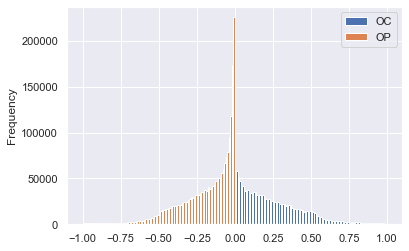

In [45]:
delta = caux.bs_call_delta(vol=df['implvol0'], S=df['S0_n'], K=df['K_n'], tau=df['tau0'], r=df['r'])
r_f = df['intrate_to_future_expiry']
tau_f = df['time_to_future_expiry']
delta = delta * np.exp(-r_f * tau_f)
delta[bl_p] -= 1
df.loc[:, 'delta_bs'] = delta

df.groupby(by='SecurityType')['delta_bs'].plot.hist(bins=100, legend=True)

#### Calculate Gamma
As we did in calculating Delta, we define Gamma as the second order sensitivity of option price with respect to future price movement.

$$ 
\frac{\partial^{2} C}{\partial F^{2}}=\frac{\partial}{\partial F} \frac{\partial C}{\partial F}=e^{-r^{F} \tau^F} \frac{\partial}{\partial F} \mathbf{N}\left(d_{1}\right)=e^{-r^{F} \tau^{F}} \frac{\partial}{\partial S} \mathbf{N}\left(d_{1}\right) \frac{\partial S}{\partial F}=e^{-2 r^{F} \tau^{F}} \frac{1}{S \sigma \sqrt{\tau^C}} \phi\left(d_{1}\right)
 $$
$$ 
\begin{aligned} d_{1} &=\frac{1}{\sigma \sqrt{\tau^{C}}}\left[\ln \left(\frac{S_{t}}{K}\right)+\left(r^{C}+\frac{\sigma^{2}}{2}\right) \tau^{C}\right] \\ d_{2} &=d_{1}-\sigma \sqrt{\tau^{C}} \end{aligned}
 $$
Put and calls have the same gamma.


/Users/rufj/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/Users/rufj/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


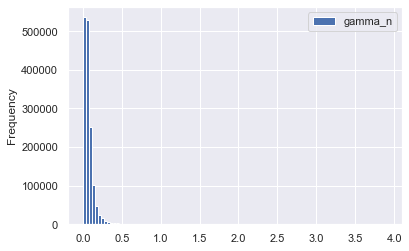

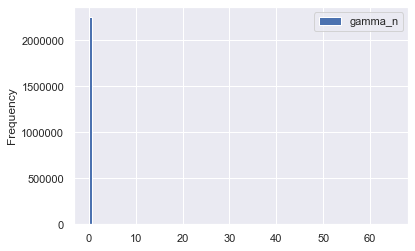

In [46]:
gamma = caux.bs_gamma(vol=df['implvol0'], S=df['S0_n'], K=df['K_n'], tau=df['tau0'], r=df['r'])
gamma = np.exp(-2. * r_f * tau_f) * gamma
df.loc[:, 'gamma_n'] = gamma

df.loc[bl_c, 'gamma_n'].plot.hist(bins=100, legend=True)
plt.show()
df.loc[bl_p, 'gamma_n'].plot.hist(bins=100, legend=True)
plt.show()

#### Step 3.7 Calculate Vega
Vega is defined in the usual way, so it is same as the ordinary Black-Scholes vega.
$$ \frac{\partial C}{\partial \sigma} = S\phi(d_1)\sqrt{\tau^C},$$
where
$$ d_1 = \frac{1}{\sigma \sqrt{\tau}}\left[ \log\left(\frac{S}{K}\right) + (r + \frac{1}{2}\sigma^2) \tau \right]. $$
Put and calls have the same vega.

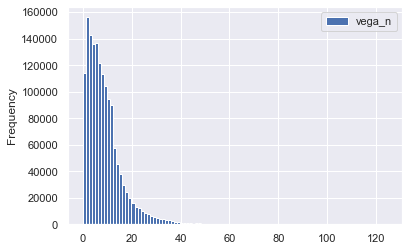

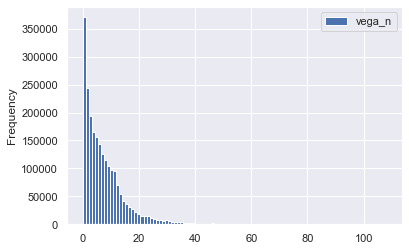

In [47]:
df['vega_n'] = caux.bs_vega(vol=df['implvol0'], S=df['S0_n'], K=df['K_n'], tau=df['tau0'], r=df['r'])

df.loc[bl_c, 'vega_n'].plot.hist(bins=100, legend=True)
plt.show()
df.loc[bl_p, 'vega_n'].plot.hist(bins=100, legend=True)
plt.show()

#### Calculate Vanna
This is the sensitivity of delta with respect to volatility,
$$
\phi (d_1)\frac{d_2}{\sigma}  e^{-r_{F} \tau_{F}} 
$$

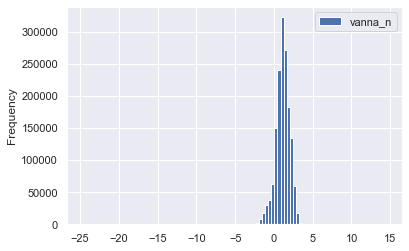

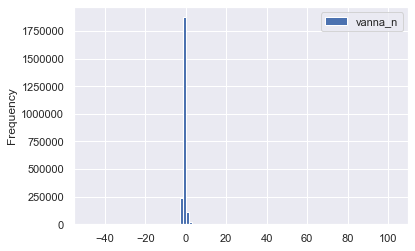

In [48]:
vanna = caux.bs_vanna(vol=df['implvol0'], S=df['S0_n'], K=df['K_n'], tau=df['tau0'], r=df['r'])
vanna = vanna * np.exp(-r_f * tau_f)
df.loc[:, 'vanna_n'] = vanna

df.loc[bl_c, 'vanna_n'].plot.hist(bins=100, legend=True)
plt.show()
df.loc[bl_p, 'vanna_n'].plot.hist(bins=100, legend=True)
plt.show()

### Step 4: Filter and store

#### Step 4.1: Filter
Filter trades with negative current time value.

In [49]:
call_bl = df['SecurityType'] == 'OC'
D = np.exp(-df['r'] * df['tau0'])

# call type intrinsic value
intrinsic_value_call = np.maximum(df['S0'] - df['K'] * D, 0.) 
bl_pos_1 = (df['V0'] - intrinsic_value_call > 0.) 
bl_pos_call = (bl_pos_1 & call_bl)

# put type intrinsic value
intrinsic_value_put =  np.maximum(df['K'] * D - df['S0'], 0.) 
bl_pos_2 = (df['V0'] - intrinsic_value_put > 0.)
bl_pos_put = (bl_pos_2 & (~call_bl))

bl_pos = (bl_pos_call | bl_pos_put)
cm.print_removal(df.shape[0], sum(bl), ori_size, 'We remove negative time value')
df = df.loc[bl_pos]

We remove negative time value. 0 samples (0.00%) are removed. We have 87.82% of original data left, yielding a size of 3837619.


#### Step 4.2: Store data

In [50]:
df.sort_values('ExecuteTime0', inplace=True)
df.reset_index(drop=True, inplace=True)

In [51]:
os.makedirs(clean_dir, exist_ok=True)
df.to_csv(clean_dir + 'options.csv')

In [52]:
" Remove the temporary folder"
shutil.rmtree(intermediate_dir)